In [15]:
import pandas as pd
import json
import glob
import tqdm
import seaborn as sns
import matplotlib.pylab as plt


from model_drift import settings



In [2]:
def converter(value):
    if isinstance(value, list):
        d = {str(i):vv for i, vv in enumerate(value)}
        d['all'] = value
        return d
    return value

In [9]:
df = []

jsonl_dir = str(settings.DATA_DIR.joinpath("ivory_cheetah_90xz8cmp"))
jsonl_files = glob.glob(f"{jsonl_dir}/*.jsonl")

for fn in tqdm.tqdm(jsonl_files):
    with open(fn, 'r') as f:
        for line in f.readlines():
            df.append({k: converter(v) for k, v in json.loads(line).items()})
df = pd.json_normalize(df)
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

4


100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


,index,error,mu.0,mu.1,mu.2,mu.3,mu.4,mu.5,mu.6,mu.7,...,logvar.119,logvar.120,logvar.121,logvar.122,logvar.123,logvar.124,logvar.125,logvar.126,logvar.127,logvar.all
0,20536686640136348236148679891455886468_k6ga29.png,0.017571,-0.015945,-0.013659,0.054871,-0.044911,0.013308,-0.059031,-0.007672,0.103230,...,-0.018902,-1.164789,0.008582,0.021520,0.017799,-0.019862,-0.004990,0.004133,-0.025369,"[-0.015835635364055634, -0.008164092898368835,..."
1,113855343774216031107737439268243531979_3k951n...,0.075379,-0.063785,-0.228841,0.063025,0.148872,0.235560,-0.026813,-0.069000,0.387944,...,-0.040039,-0.991471,-0.095479,-0.111494,-0.040676,-0.005235,0.010469,-0.038714,-0.021370,"[-0.07500659674406052, -0.04446641355752945, 0..."
2,313723174271082992847610802266403640553-4_hhi4...,0.022395,0.015599,-0.055860,0.037510,-0.034584,0.016954,-0.040431,-0.001893,0.057926,...,-0.011489,-1.242234,-0.040924,0.019805,0.023912,-0.025186,-0.025734,0.003396,-0.019047,"[0.009179182350635529, 0.03407943248748779, -0..."
3,105529804483623054726294337265160703666_6zn76a...,0.014906,0.013436,0.003932,0.012120,-0.023085,-0.016371,-0.030419,0.010042,0.030318,...,-0.012832,-1.227103,-0.034643,-0.011888,0.029016,-0.015547,0.001015,-0.007563,0.007666,"[0.019098788499832153, -0.0003490149974822998,..."
4,102185472428957491598043403159908631419_zb8kco...,0.090683,-0.085357,-0.318316,0.006658,0.150164,0.198497,-0.078318,-0.067534,0.380174,...,-0.041675,-0.965242,-0.069933,-0.127978,-0.058771,-0.005823,0.061378,-0.065650,-0.046964,"[-0.07593396306037903, 0.0031846128404140472, ..."


In [10]:
print(len(df))

12345


In [11]:
pc_df = pd.read_csv(settings.PADCHEST_FILENAME, low_memory=False)

In [12]:
pc_df_vae = pc_df.merge(df, left_on="ImageID", right_on="index", how='inner')

In [14]:
## Include this?

pc_df_vae["Projection"].value_counts()
pc_df_vae["View"] = pc_df_vae["Projection"]
pc_df_vae.loc[pc_df_vae["View"].isin(["PA", "AP_horizontal", "AP"]), "View"] = 'Frontal'
pc_df_vae['View'].value_counts()

Frontal    8346
L          3991
COSTAL        8
Name: View, dtype: int64

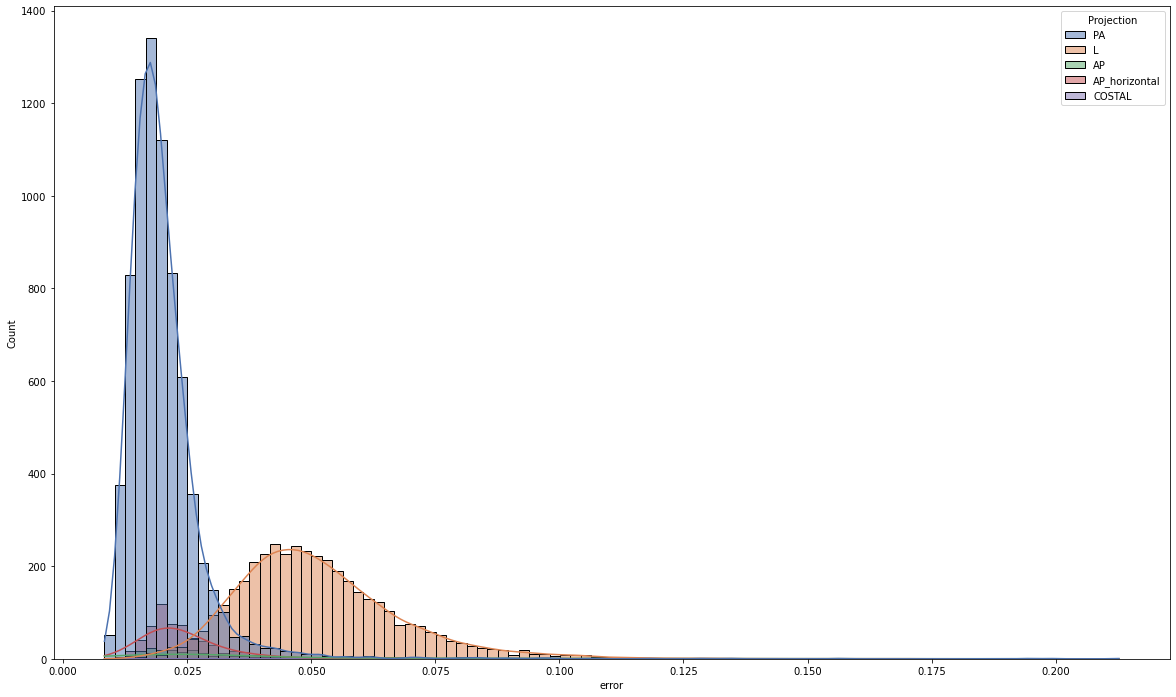

In [16]:
sns.set_palette('deep')
figsize = [20, 12]
fig, ax = plt.subplots(figsize=figsize)
_ = sns.histplot(data=pc_df_vae, x="error", hue="Projection", ax=ax, kde=True)

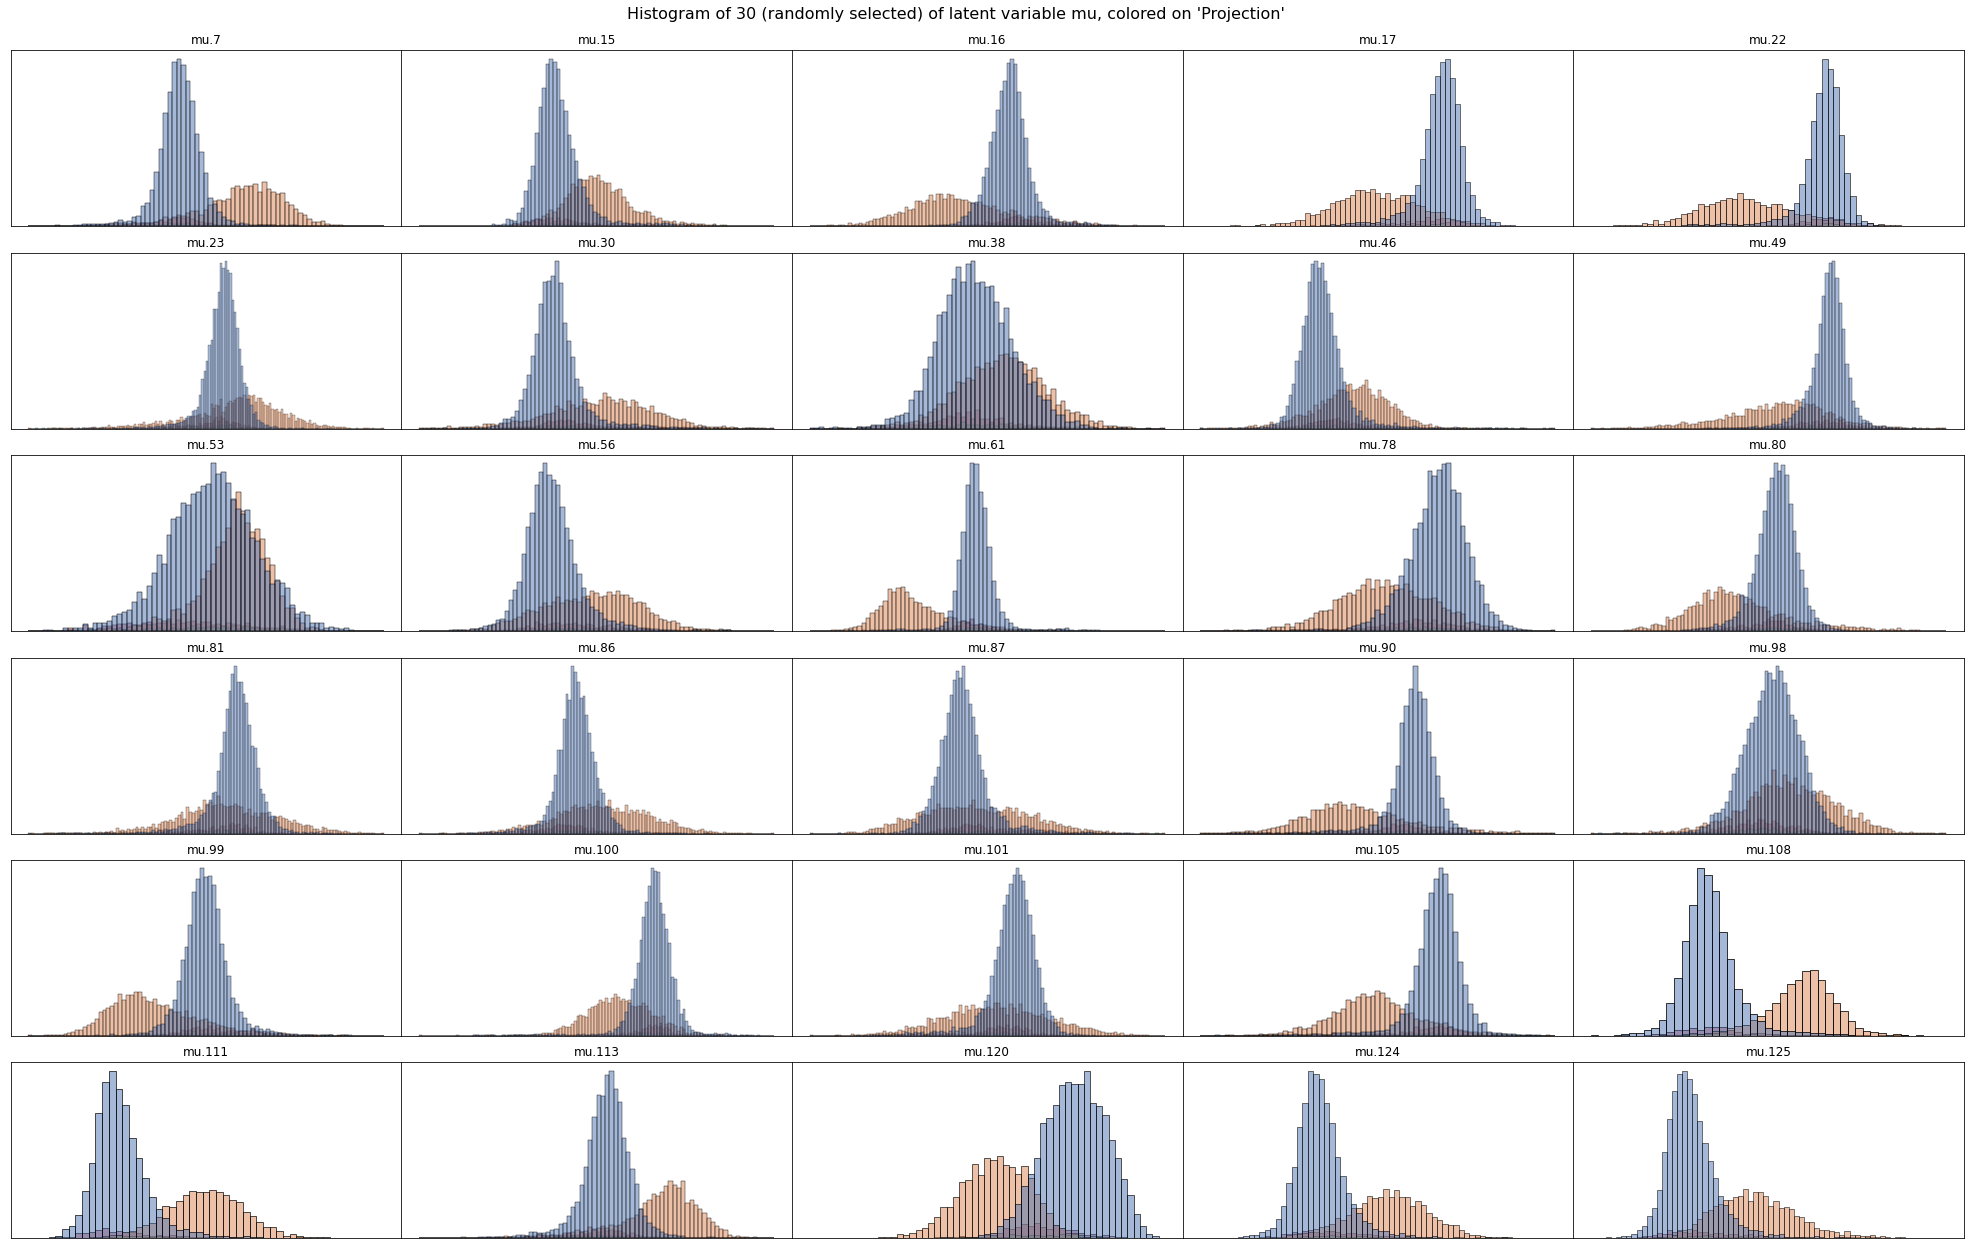

In [48]:
import random
grid_size = (6, 5)
figsize = [35, 20]
fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=figsize, gridspec_kw={'wspace':0, 'hspace':.15})
fig.set_facecolor('w')
axes = axes.flatten()
i_vals = list(range(128))

random.shuffle(i_vals)

i_vals = sorted(i_vals[:len(axes)])
col = "mu"
hue = "Projection"

s = (f"Histogram of {len(i_vals)} (randomly selected) of latent variable {col}, colored on '{hue}'")
for i, i_val in enumerate(i_vals):
    xcol = f"mu.{i_val}"
    _ = sns.histplot(data=pc_df_vae, x=xcol, hue=hue,  ax=axes[i])
    axes[i].set_title(xcol)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set(ylabel=None, xlabel=None)
    if 1:
        axes[i].get_legend().remove()
        continue
    # axes[i].legend(bbox_to_anchor=(-0.01, -0.2), loc='upper right', ncol=5)

fig.suptitle(s, fontsize=16)
fig.subplots_adjust(top=.95)